In [1]:
import cropping
import utils
import rawpy
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from color_correction import percentile_whitebalance

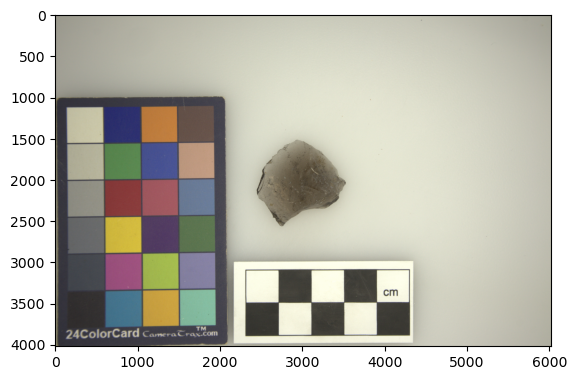

In [2]:
img = rawpy.imread(r'd:\ararat\data\files\N\38\478130\4419430\33\finds\individual\664\photos\1.CR3')
assert img is not None, "file could not be read, check with os.path.exists()"
img = img.postprocess()
plt.imshow(img)

In [3]:
lower_blue = np.array([135, 65, 35])
upper_blue = np.array([165, 255, 255])
lower_green = np.array([40, 52, 70])
upper_green = np.array([82, 255, 255]) 
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

lower_red = np.array([0, 50, 50])
upper_red = np.array([10, 255, 255])

lower_black = np.array([0, 0, 0])
upper_black = np.array([179, 255, 75])
lower_white = np.array([0, 0, 180]) 
upper_white = np.array([0, 0, 255]) 

# Create an array specify lower and upper range of colours
COLOUR_RANGE = {
    'blue': (lower_blue, upper_blue),
    'green': (lower_green, upper_green),
    'yellow': (lower_yellow, upper_yellow),
    'red': (lower_red, upper_red),
    'black': (lower_black, upper_black),
    'white': (lower_white, upper_white)
}
def getSherdCnt(img, cnts, is24Checker):
    patchPos = utils.getCardsBlackPos(img.copy(), is24Checker)
    if is24Checker:
        cnts = list(filter(lambda cnt: isSherd24(cnt, patchPos), cnts))
    else:
        cnts = list(filter(lambda cnt: isSherd4(cnt, patchPos), cnts))
    # checking if max() arg is empty also filter out the unqualified images (e.g. ones with no colorChecker)
    return max(cnts, key=cv.contourArea), patchPos

def isSherd24(cnt, patchPos):
    for pt in cnt:
        x, y = pt[0]
        for pos in patchPos.values():
            if not (x < pos[0] or x > (pos[0] + pos[2]) or y > (pos[1] + pos[3]) or y < pos[1]):
                return False
    return True

# Guess if a contour is a sherd
def isSherd4(cnt, patchPos):
    x, y, w, h = cv.boundingRect(cnt)
    for pos in patchPos.values():
        # Axis-Aligned Bounding Box
        # Test if two bound box not intersect
        if not ((x + w) < pos[0] or x > (pos[0] + pos[2]) or y > (pos[1] + pos[3]) or (y + h) < pos[1]):
            return False
    return True

In [4]:
def getCardsBlackPos(img, is24Checker = True):
    patchPos = {}
    # showImage(img)
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)  # Convert BGR to HSV
    
    black_mask = cv.inRange(
        img_hsv, COLOUR_RANGE['black'][0], COLOUR_RANGE['black'][1])
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (10, 10))
    
    if is24Checker:
        mask = cv.morphologyEx(black_mask.copy(), cv.MORPH_CLOSE, kernel, iterations=2)
    else:
        mask = cv.morphologyEx(black_mask.copy(), cv.MORPH_OPEN, kernel)
    
    cnts, _ = cv.findContours(
        mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Fill the black color to get the card
    # if is24Checker is True: 
    
    if is24Checker:
        mask = cv.drawContours(mask, cnts, -1, 255, -1)
        cnts, _ = cv.findContours(
        mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        # Get rectangle only
        cnts = list(filter(lambda x: 
                           len(cv.approxPolyDP(x, 0.01*cv.arcLength(x, True), True)) <= 6 
                            and  
                            len(cv.approxPolyDP(x, 0.01*cv.arcLength(x, True), True)) >= 4, cnts))
    else:
        cnts = list(filter(lambda x: len(cv.approxPolyDP(
            x, 0.01*cv.arcLength(x, True), True)) == 4, cnts))       

    plt.imshow(cv.drawContours(img, cnts, -1, 255, -1))
    cnts = sorted(cnts, reverse=True, key=cv.contourArea)
    # print(len(cnts))
    if len(cnts) < 2: 
        raise Exception("No black squares detected.")
    if is24Checker is True: 
        _, _, w, h = cv.boundingRect(cnts[1])
        if w/h > 2 or h/w > 2: # Determine if is scale card
            patchPos['black'] = cv.boundingRect(cnts[1]) 
            patchPos['black2'] = cv.boundingRect(cnts[0])
        else: 
            patchPos['black'] = cv.boundingRect(cnts[0]) # Second largest is the scale card 
            patchPos['black2'] = cv.boundingRect(cnts[1])
    else: 
        patchPos['black'] = cv.boundingRect(cnts[0])
        patchPos['black1'] = cv.boundingRect(cnts[1])
        patchPos['black2'] = cv.boundingRect(cnts[2])
        patchPos['black3'] = cv.boundingRect(cnts[3])        

        
    return patchPos

In [5]:
def getColorPos(img, color):
    mask = cv.inRange(img, COLOUR_RANGE[color][0], COLOUR_RANGE[color][1])
    mask_updated = cv.morphologyEx(mask, cv.MORPH_CLOSE, utils.kernel)
    contours, _ = cv.findContours(mask_updated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    contours = list(filter(lambda x: len(cv.approxPolyDP(x, 0.01 * cv.arcLength(x, True), True)) == 4, contours))
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    plt.imshow(cv.drawContours(img, contours, -1, 255, -1))
    if len(contours) > 0:
        bounding_rect = cv.boundingRect(contours[0])
        return bounding_rect
    else:
        return None

{'black': (22, 993, 2071, 3027), 'black2': (3088, 3494, 443, 400)}


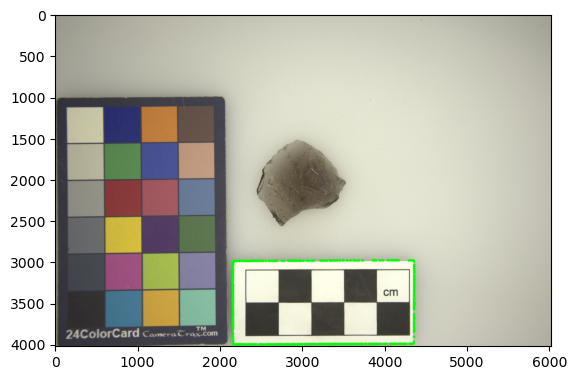

In [6]:
detector = cv.mcc.CCheckerDetector_create()
is24Checker = utils.detect24Checker(cv.cvtColor(img, cv.COLOR_RGB2BGR), detector)  # must be bgr

blur = cv.GaussianBlur(img,(5,5),0)
img_g = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
# thresholding
thresh = cropping.Thresholding(img_g, is24Checker)

# find contours
cnts, _ = cv.findContours(
thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(getCardsBlackPos(img.copy(), is24Checker))
# getCardGreenPos(img.copy())
# get the sherd contour
sherdCnt, patchPos = cropping.getSherdCnt(img, cnts, is24Checker)
print(patchPos)
img_cnt = img.copy()
cv.drawContours(img_cnt, sherdCnt, -1, (0, 255, 0), 30)
plt.imshow(img_cnt)